In [1]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.linear_model import Lasso, Ridge, ElasticNet

# Import Tree Ensemble algos
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


# classification Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import roc_curve, roc_auc_score
#roc_auc_score(y, pred)

In [2]:
df = pd.read_csv('/Users/alex/Desktop/EDS/Capstone/winequality/winequality-red.csv', sep=';')

In [10]:
X = df.drop('quality', axis=1)
y = df.quality
y

0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64

In [13]:
y1 = (y > 6).astype(int)
y1.unique()

array([0, 1])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y1, 
                                            test_size=0.2, 
                                                random_state=1234, stratify =y1)

In [15]:
pipelines = {
    'l1' : make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', solver='liblinear',random_state=123)),
    'l2' : make_pipeline(StandardScaler(), LogisticRegression(penalty='l2',random_state=123)),
    'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123))
}


In [16]:
# Lasso hyperparameters
l1_hyperparameters = { 
    'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
}

# Ridge hyperparameters
l2_hyperparameters = { 
    'logisticregression__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
}

In [22]:
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33],
    'randomforestclassifier__min_samples_leaf': [1, 3, 5, 10]
}
#pipelines['rf'].get_params()

In [19]:
# Boosted Tree hyperparameters
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}

In [20]:
hyperparameters = {
    'l1' : l1_hyperparameters,
    'l2' : l2_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters
}

In [21]:
for key in ['l1', 'l2', 'rf', 'gb']:
    if key in hyperparameters:
        if type(hyperparameters[key]) is dict:
            print( key, 'was found in hyperparameters, and it is a grid.' )
        else:
            print( key, 'was found in hyperparameters, but it is not a grid.' )
    else:
        print( key, 'was not found in hyperparameters')

l1 was found in hyperparameters, and it is a grid.
l2 was found in hyperparameters, and it is a grid.
rf was found in hyperparameters, and it is a grid.
gb was found in hyperparameters, and it is a grid.


## tuning hyperparameter

In [23]:
fitted_model ={}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], n_jobs=-1, cv=10)
    
    model.fit(X_train, y_train)
    
    fitted_model[name] =model
    print(name, 'has been fitted')

l1 has been fitted
l2 has been fitted
rf has been fitted
gb has been fitted


In [25]:

for name, model in fitted_model.items():
    print(name, model.best_params_ )
    

l1 {'logisticregression__C': 1}
l2 {'logisticregression__C': 0.1}
rf {'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 200}
gb {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 100}


In [26]:
for name, model in fitted_model.items():
    print('{} {}'.format(name,model.best_score_))


l1 0.885070127952756
l2 0.8858513779527559
rf 0.9163385826771654
gb 0.9100824311023622


In [28]:
# Calculate ROC curve from y and pred
pred = fitted_model['rf'].predict_proba(X_test)

# Get just the prediction for the positive class (1)
pred = [p[1] for p in pred]

fpr, tpr, thresholds = roc_curve(y_test, pred)
pd.DataFrame({'FPR': fpr, 'TPR' : tpr, 'Thresholds' : thresholds})

,FPR,TPR,Thresholds
0,0.000000,0.000000,1.930
1,0.000000,0.023256,0.930
2,0.000000,0.139535,0.765
3,0.003610,0.139535,0.760
4,0.003610,0.186047,0.755
...,...,...,...
72,0.610108,0.976744,0.020
73,0.660650,0.976744,0.015
74,0.747292,0.976744,0.010
75,0.851986,1.000000,0.005


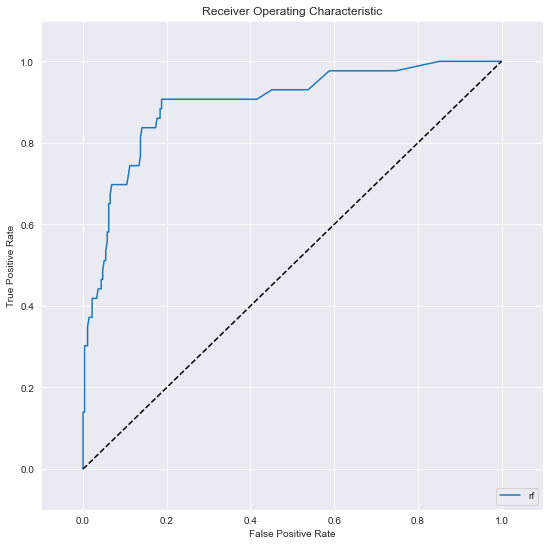

In [29]:
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='rf')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [30]:
roc_auc_score(y_test, pred)

0.8969440013432961